In [29]:
%load_ext autoreload
%autoreload 2

In [30]:
import numpy as np
import pandana as pdna
import geopandas as gpd
import pandas as pd
import math
import networkx as nx
import sys
# adding functions 
sys.path.insert(0, 'C:\\Users\\z3258367\\OneDrive - UNSW\\#PhD\\Walkability\\Other Cities\\Open-Walk-Index')
from walkability_functions import *

Choose a projected CRS to be used for all distance calculations.

In [31]:
proj_crs = "EPSG:7856"
folder = "C:\\Users\\z3258367\\OneDrive - UNSW\\#PhD\\"

## Import Data

Data sources:
1. Shape of Greater Sydney - used to clip points
2. Points of interest from OSM - using Geofabriks shapefiles as the source
3. Transport for NSW public transport stops
4. Spatial Services NSW for additional POIs
5. Employment data - processed from ABS originally

In [32]:
Sydney = gpd.read_file((folder + 
    "Walkability\\Other Cities\\Colouring data & results\\Sydney Data\\Data\\Greater_Sydney_Dissolve.shp")
    ).to_crs(proj_crs)

In [33]:
osm_poi_points = gpd.read_file(''.join((folder, 
    "Walkability\\Mavoa\\Pandana inputs\\Greater_Sydney_OSM_POIs_sp.shp")))
osm_poi_areas = gpd.read_file(folder + 
    "Walkability\\Mavoa\\Pandana inputs\\Greater_Sydney_OSM_POIs_a_sp.gpkg")
osm_transport_points = gpd.read_file(folder +
    "Walkability\\Mavoa\\Pandana inputs\\Greater_Sydney_OSM_transport_sp.shp")
osm_transport_areas =  gpd.read_file(folder +
    "Data\\OSM-australia-latest-free\\gis_osm_transport_a_free_1.shp")
osm_pow_points = gpd.read_file(folder + 
    "Data\\OSM-australia-latest-free\\gis_osm_pofw_free_1.shp")
osm_pow_areas = gpd.read_file(folder + 
    "Data\\OSM-australia-latest-free\\gis_osm_pofw_a_free_1.shp")
osm_natural = gpd.read_file(folder + 
    "Data\\OSM-australia-latest-free\\gis_osm_natural_a_free_1.shp")
osm_govt_points = gpd.read_file(folder + 
    "Walkability\\Other Cities\\Colouring data & results\\Shared Aus Data\\OSM government offices.gpkg",
                             layer = "OSM government offices points").to_crs(osm_natural.crs)
osm_govt_points['fclass'] = 'government'
osm_govt_areas = gpd.read_file(folder + 
    "Walkability\\Other Cities\\Colouring data & results\\Shared Aus Data\\OSM government offices.gpkg",
                             layer = "OSM government offices areas").to_crs(osm_natural.crs)
osm_govt_areas['fclass'] = 'government'

# the OSM POIs includes domestic swimming pools in some suburbs. This line removes swimming pools less than 100m2.
# Same for domestic tennis courts appearing as 'pitches'. Removed pitches below 450m2.
osm_poi_areas = osm_poi_areas[~((osm_poi_areas['fclass']=='swimming_pool') & (osm_poi_areas.to_crs(proj_crs).area < 100))]
osm_poi_areas = osm_poi_areas[~((osm_poi_areas['fclass']=='pitch') & (osm_poi_areas.to_crs(proj_crs).area < 450))]

In [34]:
# import SS NSW data
SS_NSW = gpd.read_file((folder + 
                        "Data\\NSW Spatial Services\\NSW_Features_of_Interest_Category.gdb"),layer='BuildingComplexPoint')
SS_NSW.to_crs(Sydney.crs, inplace = True)
SS_NSW['fclass'] = (SS_NSW['classsubtype'].astype(str) + "-" 
                    + SS_NSW['buildingcomplextype'].astype(str))

# add general cultural points
SS_NSW_gc = gpd.read_file((folder + 
                           "Data\\NSW Spatial Services\\NSW_Features_of_Interest_Category.gdb"),layer='GeneralCulturalPoint')
SS_NSW_gc.to_crs(Sydney.crs, inplace = True)
SS_NSW_gc['fclass'] = (SS_NSW_gc['classsubtype'].astype(str) + "-" 
                       + SS_NSW_gc['generalculturaltype'].astype(str) + "-gc")

SS_NSW = pd.concat([SS_NSW, SS_NSW_gc]).to_crs(proj_crs)

In [35]:
SS_names = {'4-10': 'shopping centre', '2-18': 'post office', '2-16': 'place of worship',
 '3-3': 'health centre', '3-5': 'health centre', '3-6': 'health centre',
 '1-1': 'school', '1-2': 'school', '1-3': 'school', '1-5': 'school', '1-6': 'school',
 '1-8': 'school', '1-4': 'university', '1-7': 'childcare',
 '2-2': 'art gallery', '2-11': 'library', '2-14': 'museum',
 '6-12': 'sports centre', '6-18': 'zoo', '1-6-gc': 'outdoor theater',
 '6-15': 'swimming pool', '9-2-gc': 'swimming pool',
 '6-17': 'tourist attraction', '1-2-gc': 'golf course', '1-5-gc': 'lookout',
 '1-7-gc': 'park', '1-8-gc': 'picnic area', '1-12-gc': 'sports field', '1-13-gc': 'sports field'}

SS_NSW.replace({'fclass': SS_names},inplace=True)

In [36]:
employment_centrs = gpd.read_file((folder + 
                        "Walkability\\Other Cities\\Colouring data & results\\Sydney Data\\Data\\NSW_Employment_meshblocks.gpkg"),
                                  layer='centroids').to_crs(proj_crs)

employment_centrs['category'] = 'employment'

Convert polygonal datasets to points and any multipart datasets to single part.

In [37]:
osm_pois_2 = single_points(osm_poi_areas)
osm_transport_2 = single_points(osm_transport_areas)
osm_pow_2 = single_points(osm_pow_areas)
osm_natural_2 = single_points(osm_natural)
osm_govt_2 = single_points(osm_govt_areas)

osm_df = pd.concat([osm_poi_points, osm_pois_2, osm_transport_points, osm_govt_points,
                    osm_transport_2, osm_pow_points, osm_pow_2, osm_natural_2, osm_govt_2]).to_crs(proj_crs)

osm_df = osm_df.iloc[:,0:5]

### Residential population

In [38]:
meshblocks = pd.read_csv(''.join(folder + "Data\\ABS Data\\2016 census mesh block counts.csv"))
mb_shapes = gpd.read_file(''.join(folder + "Data\\ABS Data\\2016_NSW_MBs\\MB_2016_NSW.shp"))

In [39]:
mb_shapes['MB_CODE16'] = mb_shapes['MB_CODE16'].astype('int64')

pop_mbs = mb_shapes.join(meshblocks.set_index('MB_CODE_2016'), on='MB_CODE16', how='inner', rsuffix='_2')
pop_mbs['geometry'] = pop_mbs['geometry'].to_crs(proj_crs).centroid

pop_pois = pop_mbs[(pop_mbs['Person'] > 0) & ~(pop_mbs['geometry'].isnull())][
    ['MB_CODE16', 'MB_CATEGORY_NAME_2016', 'AREA_ALBERS_SQKM', 'Person','geometry']]
pop_pois['fclass'] = 'residential'

### Categorise and weight POIs

Choose walk index weightings, and output the sums of each category and the total to check. The walk index will be out of 100 regardless of this sum, but it is important to note that eg. shopping is only '10% of the walk index' if shopping is 10 out of 100.

In [193]:
poi_parameters = pd.read_csv((folder + 
                              "Walkability\\Other Cities\\Colouring data & results\\Shared Aus Data\\poi_parameters.csv"),
                            index_col=0)

In [194]:
poi_weights = poi_parameters['weight']

poi_lambdas = poi_parameters['diminishing_returns_constant']

poi_variables = poi_parameters['variable']

poi_nums = poi_parameters['num_pois']

poi_gammas = poi_parameters['distance_constant']

In [195]:
total = sum(poi_weights)
print("total: ", total)

total:  100.3


In [18]:
# manually changing because too large
poi_nums.loc['employment'] = 100
poi_nums.loc['visiting'] = 100

C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Categorise POI data - change classes depending on your analysis and your data sources.
The purpose of the 'categorise_pois' function now is just to align the different sources of information so that their tags are in the same column, eg 'category'. It does not add a category column, because one tag can belong to multiple categories.

In [186]:
poi_categories = {'employment':['employment'],
                  'daily needs' : ['supermarket', 'greengrocer','butcher','convenience',
                                   'kiosk', 'beverages', 'alcohol', 'bakery', ],
                  'other goods' : ["shopping centre", 'mall', 'bicycle_shop', 'clothes', 'department_store', 
                                   'doityourself', 'beauty_shop', 'outdoor_shop', 
                                   'stationery', 'bookshop', 'gift_shop', 'newsagent', 
                                   'car_dealership', 'furniture_shop', 'sports_shop',
                                   'garden_centre', 'computer_shop', 'shoe_shop', 'florist', 
                                   'video_shop', 'toy_shop', 'mobile_phone_shop', 'jeweller'],
                  'services': ['hairdresser', 'optician', 'travel_agent','laundry', 'veterinary', ],                 
                  'medical': ["health centre",'chemist', 'pharmacy','doctors', 'dentist','hospital',],                  
                  'errands' : ["post office",'post_box', 'post_office', 'bank', 'atm',
                               'courthouse', 'government' ], 
                  'education' : ["childcare", 'college', 'school', 'kindergarten', 'university'],
                  'visiting' : ['residential'],
                  'cultural' : ["art gallery", "outdoor theater", 'arts_centre', 'theatre', 'artwork',
                                'library','archaeological', 'cinema', 'museum', 'ruins',],
                  'events' : ['stadium', 'marketplace', 'community_centre', 'library',],
                  'sports' : ["sports centre", "sports field", "swimming pool", "golf course", 
                              'ice_rink','pitch', 'swimming_pool', 'sports_centre', 
                              'golf_course', 'track',],
                  'further education' : ['community_centre', 'library','college'],
                  'restaurants' : ['restaurant', 'pub', 'cafe', 'fast_food', 'bar',  
                                   'food_court', 'nightclub', 'biergarten',],
                  'day trip' : ["tourist attraction", "lookout", 'attraction', 'zoo', 'castle', 
                                'theme_park',],
                  'walk/jog/ride' : ['park', 'viewpoint', 'beach'],
                  'walk dog' : ['dog_park', 'park',],
                  'religious' : ["place of worship", 'graveyard', 'christian_anglican', 'muslim',
                                'christian', 'christian_catholic', 'christian_protestant',
                                'christian_lutheran', 'hindu', 'christian_evangelical',
                                'christian_methodist', 'buddhist', 'sikh', 'christian_orthodox', 'jewish',
                                'muslim_sunni', 'taoist', 'muslim_shia'],
                  'hobby' : [],
                  'accompany children' : ['playground', 'library',],
                    }

osm_categorised = categorise_pois_new(osm_df, poi_categories, 
                                  old_column='fclass')
SS_categorised = categorise_pois_new(SS_NSW, poi_categories, 
                                 old_column='fclass')
pop_categorised = categorise_pois_new(pop_pois, poi_categories, 
                                 old_column='fclass')

Some tags are present in the dataset but not in the category dictionary.POIs with these tags have been removed:
['drinking_water' 'toilet' 'memorial' 'public_building' 'monument'
 'picnic_site' 'police' 'motel' 'shelter' 'tourist_info' 'bicycle_rental'
 'hostel' 'hotel' 'telephone' 'recycling' 'guesthouse' 'lighthouse'
 'observation_tower' 'fire_station' 'camp_site' 'town_hall' 'fountain'
 'caravan_site' 'bench' 'water_tower' 'comms_tower' 'car_wash' 'tower'
 'waste_basket' 'wastewater_plant' 'camera_surveillance' 'nursing_home'
 'car_rental' 'recycling_clothes' 'vending_parking' 'battlefield' 'chalet'
 'vending_any' 'prison' 'vending_machine' 'water_works' 'embassy'
 'water_well' 'windmill' 'recycling_glass' 'car_sharing' 'hunting_stand'
 'water_mill' 'fort' 'recycling_paper' 'railway_station' 'bus_station'
 'bus_stop' 'ferry_terminal' 'railway_halt' 'taxi' 'tram_stop' 'cliff'
 'spring' 'peak' 'glacier' 'tree' 'cave_entrance']
Some tags are present in the dataset but not in the catego

Need to remove potential overlap between different data sources (and inside some data sources). For this dataset it's around 30% because there is overlap of public transport stops between OSM and TfNSW, and overlap of things like post offices between OSM and SSNSW. Then take this combined POI set and clip it to the study area: should be the same area as is covered by the network. This is important otherwise points outside the network may be erroneously linked to the network.

In [188]:
pois = remove_duplicate_pois([osm_categorised, SS_categorised, pop_categorised], buffer=10)

Removed 1.84% duplicate points from dataframes


In [189]:
pois = pd.concat([pois, employment_centrs[['category','Jobs','geometry']], 
                  pop_categorised[['category','Person','geometry']]])

pois = gpd.clip(pois, Sydney)

In [196]:
for cat in list(poi_weights.index):
    print(cat, len(pois[pois['category'].isin(poi_categories[cat])]))

employment 6640
education 3627
daily needs 2004
other goods 2333
services 620
medical 1007
errands 2046
visiting 94583
cultural 1002
events 538
sports 8713
restaurants 5387
day trip 618
walk/jog/ride 12304
walk dog 11354
religious 2898
accompany children 2930


### Import network

In this case the network is already in the same projected CRS as everything else but I have left in the transformation to be clear.

In [99]:
# reading directly with geopandas.read_file crashes on my computer so I read into pandas then convert to gdf instead
edges_df = pd.read_csv(folder + "Walkability//Other Cities//Colouring data & results//Sydney data//Data//colouring_edges_150322.csv")
nodes_df = pd.read_csv(folder + "Walkability//Other Cities//Colouring data & results//Sydney data//Data//colouring_nodes_150322.csv")
edges = gpd.GeoDataFrame(edges_df, 
                         geometry=gpd.GeoSeries.from_wkt(edges_df['geometry'])).set_crs(proj_crs)
nodes = gpd.GeoDataFrame(nodes_df, 
                         geometry=gpd.GeoSeries.from_wkt(nodes_df['geometry'])).set_crs(proj_crs)
edges = edges.to_crs(proj_crs)
nodes = nodes.to_crs(proj_crs)

C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\IPython\core\interactiveshell.py:3331: DtypeWarning: Columns (2,4,5,7,9,13,14,19,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\IPython\core\interactiveshell.py:3331: DtypeWarning: Columns (6,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'str'>
<class 'str'>


In [22]:
#edges = gpd.clip(edges, Sydney)
#nodes = gpd.clip(nodes, Sydney)
# 
# after clip if problems:
# Make sure all nodes are in edge list
# Make sure node index is named 'id_node' or at least something, and is the actual list of ids that aligns with edge index

Pandana expects edges to have a two item index based on the same IDs as the node index.

In [100]:
nodes.set_index('connect_id',inplace=True)

edges['from_idx'] = edges['from']
edges['to_idx'] = edges['to']
edges= edges.set_index(['from_idx', 'to_idx'])
edges.index.names= ['from_idx','to_idx']

## Pandana network creation.

In [101]:
distance_network = pdna.Network(nodes['x'], nodes['y'],
                                   edges['from'], edges['to'], 
                                   edges[['length']])

maximum_dist = 2400

### Pandana network querying. 
The 'employment' category is empty because we didn't add the employment points to the POI dataset.

Free up some memory at this point...

In [98]:
del edges
del edges_df
del SS_NSW
del SS_NSW_gc
del nodes_df
# don't delete 'nodes', used later for export
# don't delete pois' obviously
del pop_mbs
del mb_shapes
del SS_categorised
del meshblocks
del pop_categorised
del employment_centrs
del osm_df
del pop_pois
del osm_categorised
del osm_poi_points
del osm_pois_2
del osm_poi_areas
del osm_transport_points
del osm_natural_2
del osm_pow_2
del osm_natural
del osm_pow_areas
del osm_pow_points
del osm_govt_points
del osm_govt_2
del osm_govt_areas
del osm_transport_2
del osm_transport_areas

NameError: name 'edges' is not defined

In [40]:
results_2 = walk_index_full(distance_network, pois, poi_categories, poi_weights, poi_gammas,
                            poi_nums, poi_lambdas, poi_variables, distance=maximum_dist)  

Finished category: employment
Maximum score: 28.9999999999903
Finished category: education
Maximum score: 12.673630625631938
Finished category: daily needs
Maximum score: 13.099457932570543
Finished category: other goods
Maximum score: 5.633341112804159
Finished category: services
Maximum score: 1.4205666543997766
Finished category: medical
Maximum score: 3.3660123810309464
Finished category: errands
Maximum score: 1.4396087656743484
Finished category: visiting
Maximum score: 9.399331874061176
Finished category: cultural
Maximum score: 1.4147887495033649
Finished category: events
Maximum score: 1.1459491643858728
Finished category: sports
Maximum score: 4.373010820433497
Finished category: restaurants
Maximum score: 3.4915372873708104
Finished category: day trip
Maximum score: 0.6793722643155311
Finished category: walk/jog/ride
Maximum score: 4.650873101766313
Finished category: walk dog
Maximum score: 2.7705129411417126
Finished category: religious
Maximum score: 1.3267590676187369
Fi

In [1]:
max(results_4['Walk_Index'])

NameError: name 'results_4' is not defined

The current approach is to find up to x closest nodes for each category within the maximum distance. Then look up the attractiveness at each one (just count for most), apply a distance decay function to each distance, apply diminishing returns to the resulting total opportunity, and sum.

An alternative approach which would be more convenient would be to use the Pandana 'aggregate' function which aggregates from all nodes within the maximum distance. However, there is limited ability to change the distance decay rate within the aggregation function. It can either be flat (no decay), linear (going to 0 at the max distance), or exponential where beta is set as 1/max distance. For walking I would like a beta of 0.001, but this requires the radius to be 1000m. If the radius is 2400m, beta is only 0.0004. This can be changed in the future if the Pandana function is updated to take a decay parameter.

## Export results

Filter the results to the original Colouring Sydney buildings only. Reduce the number of decimal places before export, distances do not need to be below 1m. Optionally export results as a csv.

In [42]:
building_results = results_4[nodes['connect_type'] == 'poi']
building_results.iloc[:,3:41] = building_results.iloc[:,3:41].round(1)

In [ ]:
building_results.to_csv((folder +
                         "Walkability\\Other Cities\\Colouring data & results\\Sydney Data\\" + 
                         "HTS_many_bf_results_070522_Sydney.csv"))

import results

In [8]:
results = pd.read_csv((folder +
                         "Walkability\\Other Cities\\Colouring data & results\\Sydney WalkTHERE results\\" + 
                         "HTS_many_bf_results_070522_Sydney.csv"))

In [23]:
results['employment_29.0']

0          0.026884
1          0.027944
2          0.000000
3          0.141319
4          0.012737
             ...   
1342816    8.242419
1342817    8.483291
1342818    8.321966
1342819    2.159055
1342820    2.172267
Name: employment_29.0, Length: 1342821, dtype: float64

In [24]:
poi_lambdas['employment'] = 0.00001653

<ipython-input-24-480265ef25f5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poi_lambdas['employment'] = 0.00001653


In [25]:
results['new_employ_29.0'] = np.array([1 - math.exp(-poi_lambdas['employment']*x) for x in results['Jobs']])*poi_weights['employment']

In [27]:
results['new_Walk_Index'] = results['Walk_Index'] - results['employment_29.0'] + results['new_employ_29.0']

In [80]:
rounding_dict = {**{k:3 for k in results.columns if "_" in k
                  and 'connect_id' not in k},
               **{k:0 for k in results.columns if "_" not in k 
                  and k != 'x'  
                  and k != 'y'}}

results = results.round(rounding_dict)

,connect_id,employment_29.0,education_13.0,daily needs_13.8,other goods_5.8,services_1.5,medical_3.6,errands_1.5,visiting_9.4,cultural_1.5,...,sports_4.4,restaurants_3.6,day trip_0.7,walk/jog/ride_5.1,walk dog_2.9,religious_1.5,accompany children_1.5,Walk_Index,new_employ_29.0,new_Walk_Index
0,1293878,0.027,5.761,0.000,1.098,0.000,0.000,0.521,2.758,0.247,...,1.704,1.091,0.084,2.486,1.510,0.628,0.389,18.248,0.002,18.224
1,1293879,0.028,6.344,0.000,1.463,0.000,0.000,0.688,2.836,0.257,...,1.726,1.378,0.097,2.693,1.646,0.680,0.367,20.144,0.002,20.119
2,1293880,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,1293881,0.141,1.896,0.000,0.382,0.000,0.000,0.181,1.645,0.059,...,1.432,0.349,0.035,0.754,0.450,0.418,0.117,7.835,0.012,7.705
4,1293882,0.013,1.910,0.000,0.498,0.000,0.000,0.226,1.038,0.154,...,1.523,0.532,0.021,1.307,0.853,0.436,0.139,8.623,0.001,8.611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1342816,3954969,8.242,8.264,6.616,2.431,0.641,1.823,0.810,8.101,0.278,...,1.471,2.030,0.000,2.167,1.389,1.018,0.641,46.387,0.790,38.935
1342817,3954970,8.483,3.396,4.313,1.374,0.302,0.856,0.603,7.621,0.617,...,2.343,1.089,0.000,2.027,1.231,0.417,0.503,35.341,0.818,27.675
1342818,3954971,8.322,3.837,3.575,1.670,0.279,0.907,0.375,7.784,0.280,...,1.880,0.999,0.066,2.766,1.773,0.433,0.851,35.988,0.799,28.465
1342819,3954972,2.159,5.651,3.433,1.038,0.000,0.224,0.163,8.343,0.068,...,2.201,0.628,0.000,3.315,2.173,0.323,0.723,30.351,0.185,28.377


Import building footprints and join the data to them, then export these polygons.

In [84]:
results_gdf = gpd.GeoDataFrame(results, geometry = gpd.GeoSeries.from_xy(results.x, results.y, crs="EPSG:7856"))

In [87]:
#doesn't include jobs column only results columns
results_gdf = results_gdf.loc[ : , [col for col in results.columns if '_' in col or col == 'geometry']]

In [88]:
buildings_foot = gpd.read_file(folder +
    "Data\\Colouring\\Building Footprints\\sydney_bf.shp").to_crs(proj_crs)

In [58]:
buildings_foot = gpd.clip(buildings_foot, Greater_Sydney)

In [90]:
# join to data
buildings_foot = gpd.sjoin(buildings_foot, results_gdf, how='left', predicate='contains')

buildings_foot.to_file(folder + 
                       "Walkability\\Other Cities\\Colouring data & results\\Sydney WalkTHERE results\\HTS_many_bf_results_230522_Sydney.gpkg")

### Import Walkscore and compare

In [64]:
walkscore = gpd.read_file(folder +
    "Walkability\\Walkscore scraping\\Interpolation\\WS_interpolate4.gpkg")

In [65]:
walkscore = walkscore.set_crs(proj_crs, allow_override=True)

In [66]:
# join to data
results_WS = gpd.sjoin(buildings_foot, walkscore, how='right', predicate='contains', rsuffix='_ws')

In [67]:
correlations = results_WS.corr(method='pearson', min_periods=1)

In [68]:
correlations['Walk_Index']

index_left      0.042296
Shape_Leng      0.534595
Shape_Area      0.508346
index_right     0.228425
x               0.411994
                  ...   
WS.number       0.134989
Walkscore       0.489255
Walkscore.y     0.489255
interpolatew    0.801150
combinedWS      0.767386
Name: Walk_Index, Length: 111, dtype: float64

### 5 categories

In [92]:
poi_categories_5 = {'employment':['employment'],
                  'shopping' : ['supermarket', 'greengrocer','butcher','convenience',
                                   'kiosk', 'beverages', 'alcohol', 'bakery',
                                "shopping centre", 'mall', 'bicycle_shop', 'clothes', 'department_store', 
                                   'doityourself', 'beauty_shop', 'outdoor_shop', 
                                   'stationery', 'bookshop', 'gift_shop', 'newsagent', 
                                   'car_dealership', 'furniture_shop', 'sports_shop',
                                   'garden_centre', 'computer_shop', 'shoe_shop', 'florist', 
                                   'video_shop', 'toy_shop', 'mobile_phone_shop', 'jeweller'],                
                  'errands' : ['hairdresser', 'optician', 'travel_agent','laundry', 'veterinary', 
                               "health centre",'chemist', 'pharmacy','doctors', 'dentist','hospital',
                               "post office",'post_box', 'post_office', 'bank', 'atm',
                               'courthouse', 'government', "place of worship", 'graveyard', 'christian_anglican', 'muslim',
                                'christian', 'christian_catholic', 'christian_protestant',
                                'christian_lutheran', 'hindu', 'christian_evangelical',
                                'christian_methodist', 'buddhist', 'sikh', 'christian_orthodox', 'jewish',
                                'muslim_sunni', 'taoist', 'muslim_shia'], 
                  'education' : ["childcare", 'college', 'school', 'kindergarten', 'university'],
                  'recreation' : ["art gallery", "outdoor theater", 'arts_centre', 'theatre', 'artwork',
                                'library','archaeological', 'cinema', 'museum', 'ruins',
                                  'stadium', 'marketplace', 'community_centre', 'library',
                                  "sports centre", "sports field", "swimming pool", "golf course", 
                              'ice_rink','pitch', 'swimming_pool', 'sports_centre', 
                              'golf_course', 'track', 'community_centre', 'library',
                                  'restaurant', 'pub', 'cafe', 'fast_food', 'bar',  
                                   'food_court', 'nightclub', 'biergarten',
                                  "tourist attraction", "lookout", 'attraction', 'zoo', 'castle', 
                                'theme_park', 'park', 'viewpoint', 'beach','dog_park','playground'],
                    }

osm_categorised = categorise_pois_new(osm_df, poi_categories_5, 
                                  old_column='fclass')
SS_categorised = categorise_pois_new(SS_NSW, poi_categories_5, 
                                 old_column='fclass')
pop_categorised = categorise_pois_new(pop_pois, poi_categories_5, 
                                 old_column='fclass')

Some tags are present in the dataset but not in the category dictionary.POIs with these tags have been removed:
['drinking_water' 'toilet' 'memorial' 'public_building' 'monument'
 'picnic_site' 'police' 'motel' 'shelter' 'tourist_info' 'bicycle_rental'
 'hostel' 'hotel' 'telephone' 'recycling' 'guesthouse' 'lighthouse'
 'observation_tower' 'fire_station' 'camp_site' 'town_hall' 'fountain'
 'caravan_site' 'bench' 'water_tower' 'comms_tower' 'car_wash' 'tower'
 'waste_basket' 'wastewater_plant' 'camera_surveillance' 'nursing_home'
 'car_rental' 'recycling_clothes' 'vending_parking' 'battlefield' 'chalet'
 'vending_any' 'prison' 'vending_machine' 'water_works' 'embassy'
 'water_well' 'windmill' 'recycling_glass' 'car_sharing' 'hunting_stand'
 'water_mill' 'fort' 'recycling_paper' 'railway_station' 'bus_station'
 'bus_stop' 'ferry_terminal' 'railway_halt' 'taxi' 'tram_stop' 'cliff'
 'spring' 'peak' 'glacier' 'tree' 'cave_entrance']
Some tags are present in the dataset but not in the catego

In [91]:
poi_parameters

,weight,distance_constant,diminishing_returns_constant,variable,num_pois
category,,,,,
employment,29.0,0.001,0.000017,Jobs,100
education,13.0,0.001,0.300000,count,25
daily needs,13.8,0.001,0.300000,count,25
other goods,5.8,0.001,0.200000,count,25
services,1.5,0.001,0.300000,count,25
medical,3.6,0.001,0.300000,count,25
errands,1.5,0.001,0.300000,count,25
visiting,9.4,0.001,0.000400,Person,100
cultural,1.5,0.001,0.300000,count,25


In [93]:
poi_parameters = pd.read_csv((folder + 
                              "Walkability\\Other Cities\\Colouring data & results\\Shared Aus Data\\poi_parameters_5.csv"),
                            index_col=0)

In [154]:
poi_weights = poi_parameters['weight'][0:5]

poi_lambdas = poi_parameters['diminishing_returns_constant'][0:5]

poi_variables = poi_parameters['variable'][0:5]

poi_nums = poi_parameters['num_pois'][0:5]

poi_gammas = poi_parameters['distance_constant'][0:5]

In [95]:
pois = remove_duplicate_pois([osm_categorised, SS_categorised, pop_categorised], buffer=10)

Removed 3.87% duplicate points from dataframes


In [96]:
pois = pd.concat([pois, employment_centrs[['category','Jobs','geometry']], 
                  pop_categorised[['category','Person','geometry']]])

pois = gpd.clip(pois, Sydney)

In [103]:
for cat in list(poi_weights.index):
    print(cat, len(pois[pois['category'].isin(poi_categories_5[cat])]))

employment 6640
education 3627
shopping 4337
errands 6571


In [156]:
results_2 = walk_index_full(distance_network, pois, poi_categories_5, poi_weights, poi_gammas,
                            poi_nums, poi_lambdas, poi_variables, distance=maximum_dist)  

Finished category: employment
Maximum score: 28.930577233122747
Finished category: education
Maximum score: 13.94099368819513
Finished category: shopping
Maximum score: 21.18839529362233
Finished category: errands
Maximum score: 8.696982340703709
Finished category: recreation
Maximum score: 23.1631145425435


In [157]:
max(results_2['Walk_Index'])

87.794845936595

In [106]:
rounding_dict = {**{k:3 for k in results_2.columns if "_" in k
                  and 'connect_id' not in k},
               **{k:0 for k in results_2.columns if "_" not in k 
                  and k != 'x'  
                  and k != 'y'}}

results_2 = results_2.round(rounding_dict)

In [107]:
results_2.to_csv((folder +
                         "Walkability\\Other Cities\\Colouring data & results\\Sydney Data\\" + 
                         "HTS_5_bf_results_230522_Sydney.csv"))

In [112]:
len(results)/len(results_2[nodes['connect_type'] == 'poi'])

1.0

In [158]:
results_2_bf = results_2[nodes['connect_type'] == 'poi']

In [126]:
results = results.set_index('connect_id')

In [159]:
results_2_bf['multi_index'] = results['new_Walk_Index']

<ipython-input-159-e79844fb73ee>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_2_bf['multi_index'] = results['new_Walk_Index']


In [117]:
len(results_2_bf)/len(results)

1.0

In [160]:
correlations = results_2_bf.corr(method='pearson', min_periods=1)

In [130]:
def get_rsq(f, y):
#fitted values, observations
    ss_res = np.dot((y - f),(y - f))
    ymean = np.mean(y)
    ss_tot = np.dot((y - ymean),(y - ymean))
    return 1 - ss_res/ss_tot

In [162]:
correlations['Walk_Index']

x                  0.252350
y                 -0.241476
Jobs               0.481890
employment1       -0.658124
employment2       -0.756112
employment3       -0.771725
employment4       -0.765366
employment5       -0.755347
employment6       -0.743256
employment7       -0.730042
employment8       -0.721070
employment9       -0.709133
employment10      -0.698060
employment_31.9    0.593800
education1        -0.750523
education2        -0.752375
education3        -0.767637
education4        -0.762355
education5        -0.757968
education6        -0.747349
education7        -0.733676
education8        -0.719455
education9        -0.703083
education10       -0.692092
education_14.3     0.821985
shopping1         -0.812824
shopping2         -0.815261
shopping3         -0.801200
shopping4         -0.795196
shopping5         -0.774957
shopping6         -0.755391
shopping7         -0.736122
shopping8         -0.721022
shopping9         -0.705768
shopping10        -0.689335
shopping_21.6      0

In [161]:
get_rsq(results_2_bf['Walk_Index'], results_2_bf['multi_index'])

0.8295941450585695

In [133]:
import matplotlib.pyplot as plt

In [197]:
results_2_bf.sort_values(by='Walk_Index')

,x,y,Jobs,employment1,employment2,employment3,employment4,employment5,employment6,employment7,...,recreation4,recreation5,recreation6,recreation7,recreation8,recreation9,recreation10,recreation_23.3,Walk_Index,multi_index
connect_id,,,,,,,,,,,,,,,,,,,,,
2128282,290503.624301,6.288488e+06,0.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,...,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,0.000000,0.000000,0.000
1535739,339582.085898,6.323170e+06,0.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,...,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,0.000000,0.000000,0.000
1731728,306727.213012,6.300738e+06,0.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,...,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,0.000000,0.000000,0.000
2472082,283834.332314,6.327525e+06,0.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,...,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,0.000000,0.000000,0.000
2472084,291768.545288,6.223218e+06,0.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,...,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,0.000000,0.000000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3951028,334259.817110,6.251233e+06,130604.179274,132.876007,136.264008,151.716003,156.281998,157.630997,183.921997,200.565994,...,21.552999,54.242001,84.176003,91.779999,96.402000,102.348000,130.304993,22.296269,87.614956,78.640
3951044,334251.594271,6.251235e+06,130589.041843,141.210999,143.378998,144.598999,149.294006,164.617004,175.585007,204.313995,...,29.888000,45.904999,83.443001,92.511002,104.737000,110.682999,121.968002,22.256166,87.623479,78.630
3951154,334263.266423,6.251232e+06,130671.718495,128.975998,132.363998,152.382004,154.925995,160.841003,187.132004,196.666000,...,21.294001,57.452000,80.276001,92.501999,94.989998,98.447998,133.514999,22.338562,87.646523,78.667


In [146]:
results.loc[:, [x for x in results.columns if "_" in x]]

,employment_29.0,education_13.0,daily needs_13.8,other goods_5.8,services_1.5,medical_3.6,errands_1.5,visiting_9.4,cultural_1.5,events_1.5,sports_4.4,restaurants_3.6,day trip_0.7,walk/jog/ride_5.1,walk dog_2.9,religious_1.5,accompany children_1.5,Walk_Index,new_employ_29.0,new_Walk_Index
connect_id,,,,,,,,,,,,,,,,,,,,
1293878,0.027,5.761,0.000,1.098,0.000,0.000,0.521,2.758,0.247,0.000,1.704,1.091,0.084,2.486,1.510,0.628,0.389,18.248,0.002,18.224
1293879,0.028,6.344,0.000,1.463,0.000,0.000,0.688,2.836,0.257,0.000,1.726,1.378,0.097,2.693,1.646,0.680,0.367,20.144,0.002,20.119
1293880,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1293881,0.141,1.896,0.000,0.382,0.000,0.000,0.181,1.645,0.059,0.000,1.432,0.349,0.035,0.754,0.450,0.418,0.117,7.835,0.012,7.705
1293882,0.013,1.910,0.000,0.498,0.000,0.000,0.226,1.038,0.154,0.000,1.523,0.532,0.021,1.307,0.853,0.436,0.139,8.623,0.001,8.611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3954969,8.242,8.264,6.616,2.431,0.641,1.823,0.810,8.101,0.278,0.606,1.471,2.030,0.000,2.167,1.389,1.018,0.641,46.387,0.790,38.935
3954970,8.483,3.396,4.313,1.374,0.302,0.856,0.603,7.621,0.617,0.271,2.343,1.089,0.000,2.027,1.231,0.417,0.503,35.341,0.818,27.675
3954971,8.322,3.837,3.575,1.670,0.279,0.907,0.375,7.784,0.280,0.299,1.880,0.999,0.066,2.766,1.773,0.433,0.851,35.988,0.799,28.465


In [182]:
results[(results_2_bf['multi_index']<2) & (results_2_bf['Walk_Index']>20)].loc[:, [x for x in results.columns if "_" in x]]

,employment_29.0,education_13.0,daily needs_13.8,other goods_5.8,services_1.5,medical_3.6,errands_1.5,visiting_9.4,cultural_1.5,events_1.5,sports_4.4,restaurants_3.6,day trip_0.7,walk/jog/ride_5.1,walk dog_2.9,religious_1.5,accompany children_1.5,Walk_Index,new_employ_29.0,new_Walk_Index
connect_id,,,,,,,,,,,,,,,,,,,,
3933464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.326,0.0,0.0,0.088,0.0,0.362,0.107,0.0,0.0,1.877,0.0,1.877
3933465,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.404,0.0,0.0,0.000,0.0,0.103,0.000,0.0,0.0,1.502,0.0,1.502
3933466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.332,0.0,0.0,0.091,0.0,0.375,0.110,0.0,0.0,1.902,0.0,1.902
3933467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.401,0.0,0.0,0.000,0.0,0.104,0.000,0.0,0.0,1.501,0.0,1.501
3933469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.384,0.0,0.0,0.000,0.0,0.096,0.000,0.0,0.0,1.476,0.0,1.476
3933471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.332,0.0,0.0,0.000,0.0,0.000,0.000,0.0,0.0,1.328,0.0,1.328
3933472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.326,0.0,0.0,0.095,0.0,0.392,0.115,0.0,0.0,1.923,0.0,1.923
3933475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.386,0.0,0.0,0.000,0.0,0.108,0.000,0.0,0.0,1.490,0.0,1.490
3933477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.363,0.0,0.0,0.000,0.0,0.000,0.000,0.0,0.0,1.359,0.0,1.359


In [184]:
results_gdf[results_gdf['connect_id']==3933464].to_crs("EPSG:4326")

,connect_id,employment_29.0,education_13.0,daily needs_13.8,other goods_5.8,services_1.5,medical_3.6,errands_1.5,visiting_9.4,cultural_1.5,...,restaurants_3.6,day trip_0.7,walk/jog/ride_5.1,walk dog_2.9,religious_1.5,accompany children_1.5,Walk_Index,new_employ_29.0,new_Walk_Index,geometry
1321363,3933464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.326,...,0.088,0.0,0.362,0.107,0.0,0.0,1.877,0.0,1.877,POINT (151.16215 -33.64340)


In [183]:
results_2_bf[(results_2_bf['multi_index']<2) & (results_2_bf['Walk_Index']>20)]

,x,y,Jobs,employment1,employment2,employment3,employment4,employment5,employment6,employment7,...,recreation4,recreation5,recreation6,recreation7,recreation8,recreation9,recreation10,recreation_23.3,Walk_Index,multi_index
connect_id,,,,,,,,,,,,,,,,,,,,,
3933464,329561.287791,6.275868e+06,0.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,...,114.436996,151.169998,181.067993,288.893005,354.260010,491.411011,593.914978,20.597208,20.597208,1.877
3933465,329507.463052,6.276287e+06,0.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,...,55.743999,62.285999,77.892998,166.106995,223.828003,256.597992,290.032013,21.802941,21.802941,1.502
3933466,329554.412011,6.275833e+06,0.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,...,79.357002,186.250000,216.147995,319.179993,323.972992,526.491028,558.835022,20.685760,20.685760,1.902
3933467,329506.524051,6.276275e+06,0.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,...,42.769001,64.917999,75.261002,179.082001,236.802994,269.572998,277.057007,21.764575,21.764575,1.501
3933469,329525.067128,6.276345e+06,0.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,...,75.261002,103.822998,118.028000,140.177002,161.544006,194.313995,287.169006,21.505727,21.505727,1.476
3933471,329848.713106,6.276804e+06,0.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,...,110.161003,123.024002,157.709000,300.712006,327.688995,390.281006,463.871002,20.697525,20.697525,1.328
3933472,329531.054037,6.275798e+06,0.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,...,79.633003,230.800995,260.699005,274.628998,368.523987,514.283997,571.041992,20.597706,20.597706,1.923
3933475,329488.701449,6.276236e+06,0.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,...,55.743999,77.644997,118.028000,221.848999,234.289993,279.570007,312.339996,21.534859,21.534859,1.490
3933477,329909.825005,6.276828e+06,0.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,...,56.872002,66.153999,91.556999,366.864014,393.841003,456.433014,530.023010,21.169059,21.169059,1.359


Text(0, 0.5, '19 category index')

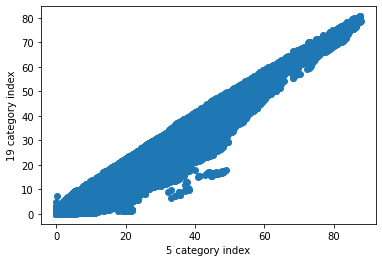

In [163]:
fig, ax = plt.subplots()
ax.scatter(results_2_bf['Walk_Index'], results_2_bf['multi_index'])
ax.set_xlabel('5 category index')
ax.set_ylabel('19 category index')